In [2]:
import os
import numpy as np
import mne
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from pp import pp as pp
import pyeeg as pg
import math
from math import floor

In [3]:
"""
This work will be used to
    1-	Read all Experiment Data 
    2-	Separate Channels into Matrices (Subject x SignalinTime)
    3-	Find breaks in time of the experiment to build a samples list
    4-  Do wavelet transform on data 
    5-  Apply K-means
    6-  Neural Network for classification?? 
"""

'\nThis work will be used to\n    1-\tRead all Experiment Data \n    2-\tSeparate Channels into Matrices (Subject x SignalinTime)\n    3-\tFind breaks in time of the experiment to build a samples list\n    4-  Do wavelet transform on data \n    5-  Apply K-means\n    6-  Neural Network for classification?? \n'

Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-010/eeg/sub-010_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-017/eeg/sub-017_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-016/eeg/sub-016_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-011/eeg/sub-011_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-018/eeg/sub-018_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-002/eeg/sub-002_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-005/eeg/sub-005_task-Experiment_eeg.fdt
Reading /Users/viniciussilvestrelourenco/Documents/GitHub/EEG-Sound-Classifier/data/sub-004/eeg/sub-004_

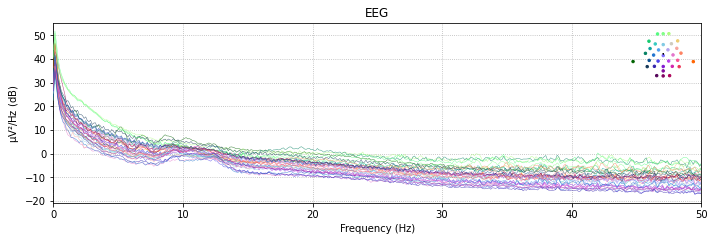

Using matplotlib as 2D backend.


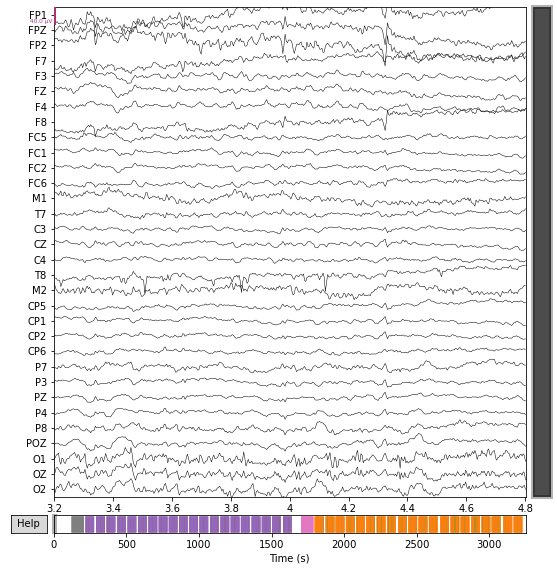

In [4]:
"""
1- Read All Experiment Data Into a main RAW Vector
"Ingest data"
"""

#Read
dataset_path = "data"



###
verbose = 1 #Activate Verbose (1) for tests, or (0) otherwise
###


#Crawler to find files
##Read the files and add to an eegraw vector of EEGLAB objects
eegraw, filename = pp.read_eeg(dataset_path)

"""
Extract Subject Number from each data file
"""
#Test if file name saver worked:
subject = []
for file in filename:
    if verbose == 1:
        print(file)
    subject.append(file[5:7])

for subj in subject:
    if verbose == 1:
        print(subj)
    

"""
Creat an index for each subject file number to assist in data organization
"""
#Find Index of each Subject number
index = []
i=1
while i <= len(subject):
    j=0
    for subj in subject:
        if i < 10:
            k = f'0{i}'
            if subj == k:
                index.append(j)
                if verbose == 1:
                    print(j)
            else:
                j+=1
        else:
            if subj == str(i):
                index.append(j)
                if verbose == 1:
                    print(j)
            else:
                j+=1
    i+=1
# Index[0] is the index position of subject 01.


"""
2- Separate Channels into Matrices
"""

#Build a Channels Dictionary
chn_dict = {
    1: 'FP1',
    2: 'FPZ',
    3: 'FP2',
    4: 'F7',
    5: 'F3',
    6: 'FZ',
    7: 'F4',
    8: 'F8',
    9: 'FC5',
    10: 'FC1',
    11: 'FC2',
    12: 'FC6',
    13: 'M1',
    14: 'T7',
    15: 'C3',
    16: 'CZ',
    17: 'C4',
    18: 'T8',
    19: 'M2',
    20: 'CP5',
    21: 'CP1',
    22: 'CP2',
    23: 'CP6',
    24: 'P7',
    25: 'P3',
    26: 'PZ',
    27: 'P4',
    28: 'P8',
    29: 'POZ',
    30: 'O1',
    31: 'OZ',
    32: 'O2'
}

## Read how many time points are in each file and save on raw_points_size
i = 0
raw_points_size = []
while i < len(subject):
    raw_points_size.append(eegraw[i].n_times)
    if verbose == 1:
        print(eegraw[i].n_times)
    i+=1

#Plotting to test if data is OK
if verbose == 1: 
    eegraw[0].plot_psd(tmin=0,tmax=2304000, fmin=0,fmax=50,area_mode='std') #Uses the Welch Method by chunking the signal in time
    eegraw[1].plot(events=None, n_channels=32, duration=1.6, start=3.2)

In [5]:
eegraw[1].info

<Info | 8 non-empty values
 bads: []
 ch_names: FP1, FPZ, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 32 items (32 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 256.0 Hz
>

In [6]:
""" Preprocessing """

class pp_mne:
    
    def get_sample(eegraw, subject=0, start_second=0 , sample_time_size=0.4, channels = 32): #start and sample_time_size in seconds
        """
            Method focused on getting a sample of EEG data from a list of EEGRAW objects (mne extracted)
            
            ::Parameters:: 
            channels:          int       amount of channels to extract in the sample
            sample_time_size:  float     size of sample in seconds
            start_second:      float     initial second to start extraction
            subject:           int       subject from the list to extract data from
            
            ::Input::
            eegraw[]:          list      list of eegraw mne objects
            
            ::Output::
            sample[][]:        list[][]  data sample given in channels x datapoints 
        """
            

        sampling_freq = eegraw[subject].info['sfreq'] #Extract sampling frequency from eegraw object
        stop_second = start_second + sample_time_size 
        selected_channels = np.arange(start = 0, stop = channels) 

        ## Select datapoints from mne library eegraw object using .get_data() ##
        sample = eegraw[subject].get_data(picks=selected_channels,
                                    start=int(start_second*sampling_freq),
                                    stop=int(stop_second*sampling_freq))

        return sample

    def get_samples(eegraw):
        """
            Method to extract all samples given the stanford dataset descriptions
            
            ::Predefined on Paper Parameters::
                blocks = 8 units
                trials = 180 units
                chords = 4 units
                time_chord = 0.4 seconds
                channels = 32 units
            
            ::Input:: 
                eegraw[]:          list                 list of eegraw mne objects
            
            ::Output:: 
                samples            list[][][][][][]     list of samples given in subjects x blocks x trials x chords x channels x datapoints
            
        """

        subjects = len(eegraw)
        blocks = 8
        trials = 180
        chords = 4
        time_chord = 0.4 #seconds
        selected_channels = np.arange(start = 0, stop = len(eegraw[0].ch_names))

        samples = [[[[[]]*chords]*trials]*blocks]*subjects #define a list of lists with the required shape
        
        i=0
        while i < subjects:
            time = 0
            j=0
            while j < blocks:
                k=0
                while k < trials:
                    l = 0
                    while l < chords:
                        samples[i][j][k][l] = pp_mne.get_sample(eegraw, subject=i, start_second=time, sample_time_size = 0.4)
                        time = time + 0.4
                        l += 1
                    k += 1
                j += 1
            i += 1

        return samples
    
    def get_samples_np(eegraw):
        """
            Method to extract all samples given the stanford dataset descriptions
            
            ::Predefined on Paper Parameters::
                blocks = 8 units
                trials = 180 units
                chords = 4 units
                time_chord = 0.4 seconds
                channels = 32 units
            
            ::Input:: 
                eegraw[]:          list                 list of eegraw mne objects
            
            ::Output:: 
                samples            numpy array     list of samples given in subjects x blocks x trials x chords x channels x datapoints
            
        """

        subjects = len(eegraw)
        blocks = 8
        trials = 180
        chords = 4
        time_chord = 0.4 #seconds
        selected_channels = 32
        datapoints = 102

        samples = np.zeros((subjects,blocks,trials,chords,selected_channels,datapoints))
        
        i=0
        while i < subjects:
            time = 0
            j=0
            while j < blocks:
                k=0
                while k < trials:
                    l = 0
                    while l < chords:
                        samples[i][j][k][l] = pp_mne.get_sample(eegraw, subject=i, start_second=time, sample_time_size = 0.4)[:,0:datapoints]
                        time = time + 0.4
                        l += 1
                    k += 1
                j += 1
            i += 1

        return samples
        
    def plot_sample(sample):
        """
            Method to plot samples of EEG data in numpy array
        """

        ## Plotting the extracted data
        i = 0

        while i < np.shape(sample)[0]: #smaller than the amount of channels in sample
        #while i <= 0: #smaller than a certain amount of channels
            ### time dimension
            y = sample[i]
            ### data dimension
            stop = np.shape(sample[0])[0]
            x = np.arange(start=0,stop = stop)

            plt.plot(x, y)
            plt.xlabel('Time')
            plt.ylabel('Data')
            plt.title('Plot of channel 0')

            i += 1

## Test for 1 sample ##
#a = pp_mne.get_sample(eegraw,0,0,0.4,1)
#pp_mne.plot_sample(a)

## Test for all samples ##
#samples = pp_mne.get_samples(eegraw)
#pp_mne.plot_sample(samples[0][0][0][0][0:1])

In [7]:
#Extract samples from EEGRaw
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

samples = pp_mne.get_samples_np(eegraw)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 10:19:59
Current Time = 10:23:50


In [8]:
#time = 0
#samples = np.zeros((18,8,180,4,32))
#samples.shape
#pp_mne.get_sample(eegraw, subject=i, start_second=time, sample_time_size = 0.4)[:,0:102].shape

# Paper Process
EEG Signals >> Wavelet Transform >> K-Means Clustering >> Probability Distributions >> MLPNN Classifier >> Classification Results



In [9]:
"""
    Example of Discrete Wavelet Transform using pywavelets lib 
    Reference: https://pywavelets.readthedocs.io/en/0.2.2/ref/dwt-discrete-wavelet-transform.html
    
    :: Method Call ::
    
        Discrete Wavelet Transform
            pywt.idwt(cA, cD, wavelet, mode='symmetric', axis=-1)
        
        Multilevel Decomposition 
            pywt.wavedec(data, wavelet, mode='sym', level=None)
        
        Inverse Discrete Wavelet Transform
            pywt.idwt(cA, cD, wavelet, mode='symmetric', axis=-1)
        
        Multilevel Reconstruction
            pywt.waverec(coeffs, wavelet, mode='symmetric', axis=-1)
        
    
    :: Modes :: 
    
        zpd - Zero-padding
        cpd - Constant-padding
        sym - Symmetric-padding
        ppd - Periodic-padding
        sp1 - Smooth-padding
        per - Perioditization
    
    :: Wavelets ::
    
        :: Discrete ::

             bior - Discrete Biortogonal family
              Orthogonal:     False
              Biorthogonal:   True
              Symmetry:       symmetric

             coif family - Discrete Coiflets
              Orthogonal:     True
              Biorthogonal:   True
              Symmetry:       near symmetric

             db family - Discrete Daubechies
              Orthogonal:     True
              Biorthogonal:   True
              Symmetry:       asymmetric

             dmey - Discrete Meyer family (FIR approximation)
              Orthogonal:     True
              Biorthogonal:   True
              Symmetry:       symmetric

             sym2 - Discrete Symlets
              Orthogonal:     True
              Biorthogonal:   True
              Symmetry:       near symmetric

             haar - Discrete Haar 
              Orthogonal:     True
              Biorthogonal:   True
              Symmetry:       asymmetric

             rbio - Discrete Reverse Biorthogonal
              Orthogonal:     False
              Biorthogonal:   True
              Symmetry:       symmetric
        
        ::Continuous

             fbsp - Continuous Frequency B-Spline wavelets
              Symmetry:       asymmetric
              Complex CWT:    True

             gaus1 - Continuous Gaussian
              Symmetry:       anti-symmetric
              Complex CWT:    False

             mexh - Continuous Mexican hat wavelet
              Symmetry:       symmetric
              Complex CWT:    False

             morl - Continuous Morlet Wavelet
              Symmetry:       symmetric
              Complex CWT:    False

             shan - Continuous Shannon Wavelets
              Symmetry:       asymmetric
              Complex CWT:    True

             cgau - Continuous Complex Gaussian wavelets
              Symmetry:       anti-symmetric
              Complex CWT:    True

             cmor - Continuous Complex Morlet wavelets
              Symmetry:       asymmetric
              Complex CWT:    True
      
    :: Tests :: 
    >> to verify Discrete wavelets
        wavelet = pywt.Wavelet("name")
        print(wavelet)
        
    >> to verify Continuous wavelets
        wavelet = pywt.ContinuousWavelet("name")
        print(wavelet)
        
    >> To check wavelet list
        pywt.wavelist()
        
"""

import pywt

# Simple Decomposition
(A, D) = pywt.dwt([1,2,3,4,5,6], 'db1', mode='sp1')
print(A)
print(D)

#Recovery through idwt
print(pywt.idwt(A, D, 'db1', mode='sp1'))

#Multilevel Decomposition
coeffs = pywt.wavedec([1,2,3,4,5,6,7,8], 'haar', level=1)
print(coeffs)

pywt.waverec(coeffs, 'haar')

[2.12132034 4.94974747 7.77817459]
[-0.70710678 -0.70710678 -0.70710678]
[1. 2. 3. 4. 5. 6.]
[array([ 2.12132034,  4.94974747,  7.77817459, 10.60660172]), array([-0.70710678, -0.70710678, -0.70710678, -0.70710678])]


array([1., 2., 3., 4., 5., 6., 7., 8.])

In [10]:
samples.shape
print(type(samples[0][0][0][0]))

<class 'numpy.ndarray'>


In [11]:
class process:
    
    def get_dwt(samples, wavelet="haar", mode="sym"):
        """
            Do Wavelet transform over all samples
        """
        
        subjects = len(samples)
        blocks = len(samples[0])
        trials = len(samples[0][0])
        chords = len(samples[0][0][0])
        channels = len(samples[0][0][0][0])

        cA = [[[[[[]]*channels]*chords]*trials]*blocks]*subjects #Define the wavelet Approximation coefficient list
        cD = [[[[[[]]*channels]*chords]*trials]*blocks]*subjects #Define the wavelet Detail coefficient list


        i=0
        while i < subjects:
            time = 0
            j=0
            while j < blocks:
                k=0
                while k < trials:
                    l = 0
                    while l < chords:
                        m = 0
                        while m < channels:
                            cA[i][j][k][l][m], cD[i][j][k][l][m] = pywt.dwt(samples[i][j][k][l][m], wavelet = wavelet, mode = mode)
                            m += 1
                        l += 1
                    k += 1
                j += 1
            i += 1
            
        return cA, cD
    
    def get_dwt_np(samples, wavelet="haar", mode="sym"):
        """
            Do Wavelet transform over all samples
        """
        
        subjects = samples.shape[0]
        blocks = samples.shape[1]
        trials = samples.shape[2]
        chords = samples.shape[3]
        channels = samples.shape[4]
        datapoints = 51

        cA = np.zeros((subjects,blocks,trials,chords,channels,datapoints)) #Define the wavelet Approximation coefficient list
        cD = np.zeros((subjects,blocks,trials,chords,channels,datapoints)) #Define the wavelet Detail coefficient list


        i=0
        while i < subjects:
            time = 0
            j=0
            while j < blocks:
                k=0
                while k < trials:
                    l = 0
                    while l < chords:
                        m = 0
                        while m < channels:
                            cA[i,j,k,l,m], cD[i,j,k,l,m] = pywt.dwt(samples[i,j,k,l,m], wavelet = wavelet, mode = mode)
                            m += 1
                        l += 1
                    k += 1
                j += 1
            i += 1
            
        return cA, cD

In [12]:
from datetime import datetime

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

cA, cD = process.get_dwt_np(samples, wavelet="db1")

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 10:23:50
Current Time = 10:25:00


In [13]:
A = np.array([[[1,1], [1,1], [1, 1]],[[2,2], [2,2], [2, 2]]])
print(A[0:1, 0:2, 0:2])


[[[1 1]
  [1 1]]]


In [14]:
#Initialize X for K-Means with cA

subjects = 1
blocks = 1
trials = 180
chords = 1
channels = 32

cA_size = cA.shape[5]
cD_size = cD.shape[5]

#Define X
x = np.zeros((subjects*blocks*trials*chords*channels,cA_size+cD_size))

print(x.shape)
print(x[1])

#Get x from cA and cD
x[:,0:cA_size] = cA[0:subjects,0:blocks,0:trials,0:chords,0:channels].reshape((subjects*blocks*trials*chords*channels,cA_size))
x[:,cA_size:cA_size+cD_size] = cD[0:subjects,0:blocks,0:trials,0:chords,0:channels].reshape((subjects*blocks*trials*chords*channels,cD_size))

print(x[1])

(5760, 102)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[-1.74664966e-02 -1.74652288e-02 -1.74652219e-02 -1.74683853e-02
 -1.74575805e-02 -1.74693589e-02 -1.74687264e-02 -1.74841598e-02
 -1.74761434e-02 -1.74743529e-02 -1.74626511e-02 -1.74691248e-02
 -1.74700453e-02 -1.74750959e-02 -1.74713697e-02 -1.74730857e-02
 -1.74662121e-02 -1.74657888e-02 -1.74699693e-02 -1.74643995e-02
 -1.74762346e-02 -1.74696676e-02 -1.74679330e-02 -1.74643153e-02
 -1.74652254e-02 -1.74655409e-02 -1.74757878e-02 -1.74657308e-02
 -1.74754770e-02 -1.74751670e-02 -1.74735877e-02 -1.74728185e-02
 -1.74703022e-02 -1.74806933e-02 -1.74710984e-02 -1.74756352e-02
 -1.74706178e-02 -1.74779947e-02 -1.74677638e-02 -1.74718048e-02
 -1.74663793e-02 -1.747469

x: [[-1.07251067e-02 -1.07300474e-02 -1.07272183e-02 ... -1.09463444e-05
   4.74465888e-06 -4.58100233e-06]
 [-1.74664966e-02 -1.74652288e-02 -1.74652219e-02 ... -1.37844390e-05
   2.52804485e-06 -2.33883854e-06]
 [-1.55643835e-02 -1.55631744e-02 -1.55651866e-02 ... -1.54872958e-05
   1.77674389e-06 -1.84303516e-06]
 ...
 [-9.86765165e-03 -9.87210387e-03 -9.87320700e-03 ... -2.01048964e-06
   2.65751997e-06  1.91139802e-06]
 [-7.18726327e-03 -7.19258211e-03 -7.19455117e-03 ... -8.85955078e-07
  -1.55888043e-06  2.05779122e-06]
 [ 3.76846980e-02  3.76808641e-02  3.76765317e-02 ... -6.83628626e-07
  -5.25082028e-06  2.68617713e-06]] , shape:5760
c: [[-1.71766047e-02 -2.41405836e-02 -1.72113476e-02 -1.89693678e-02
  -3.73464422e-02 -9.70041655e-03  2.58771534e-03 -1.13671679e-02
  -9.43250540e-03 -1.05071578e-02 -8.73145196e-03 -2.52275143e-02
   1.18905444e-02  7.92670969e-03 -1.28950303e-02 -5.73232966e-03
   1.02662850e-02 -3.95970816e-03  1.30956115e-03  2.13476661e-02
  -9.41062491e-

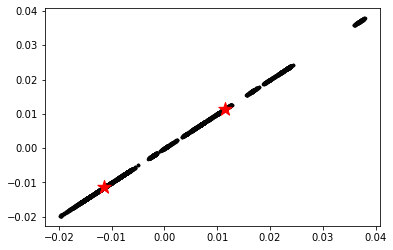

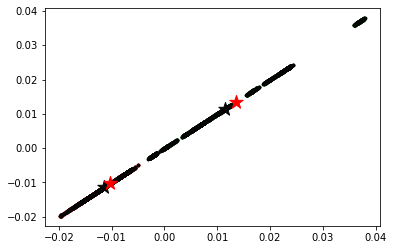

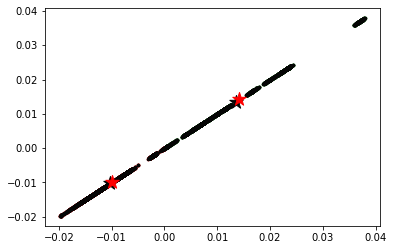

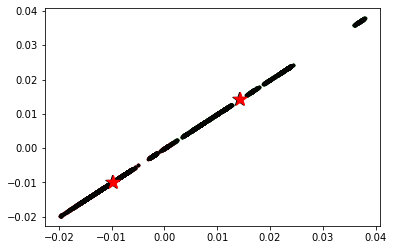

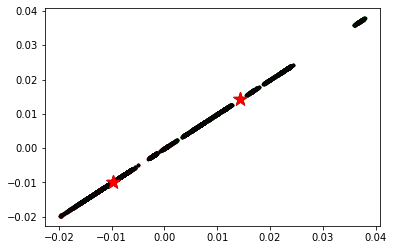

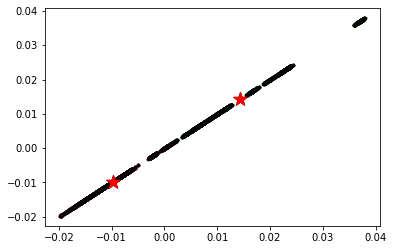

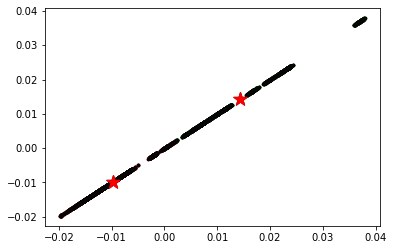

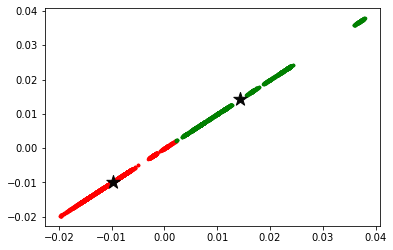

In [15]:
"""Working K-Means I built from Learning from Data class"""

import numpy as np
import matplotlib as plt
import pandas as pd

features = x.shape[1]
points = x.shape[0]

##::Initiate X::
#x = np.random.randint(-100,100,(points,features))
#x = x.astype(float)
label = np.zeros(x.shape[0])
number_clusters = 2

#x = np.array([[1.0,1.0,1.0],[10.0,15.0,20.0],[100.0,100.0,100.0]])
print(f'x: {x} , shape:{x.shape[0]}')


#Initiating the clusters
mean = np.mean(x, axis = 0)
std = np.std(x, axis = 0)
number_features = x.shape[-1] 
c = np.random.randn(number_clusters,number_features)*std + mean
c = c.astype(float)
print(f'c: {c}')

#Initiating 
loss = 1.0
loss1 = 2.0
miter = 0


while loss>0.001 and miter<300 and loss1 != loss:
    loss1 = loss
    """STEP 1 - Updating labels for each point"""
    print('------------------- Step 1 --------------------')
    # Here we are doing the subtraction of each point by the centroids,
    # the smallest one is used as centroid label (designation of which centroid is the nearest)
    #print(f'iter{miter}:')
    #print(f'{c}')
    i = 0
    j = 0
    mid = np.zeros(c.shape[0])
    for i in range(x.shape[0]):
        for j in range(c.shape[0]):
            mid[j] = (np.linalg.norm(x[i]-c[j]))**2
            #print(f'Point[{i}] - mid[{j}]:{mid[j]}' )
            j += 1

        label[i] = np.argmin(mid)
        #print(f'Label[{i}] = {label[i]}')
        j = 0
        i += 1
    #print(f'labels_exit:{label}')
    
    """Step 2 - Update the centroids"""
    #print('------------------- Step 2 --------------------')
    i = 0
    j = 0
    soma = np.zeros(c.shape).astype(float)
    countlabels = np.zeros(c.shape[0])
    #print(f'soma: {soma}')
    #print(f'c:{c}')
    for i in range(c.shape[0]):
        j=0
        for j in range(x.shape[0]):
            if label[j].astype(int) == i:
                soma[i] += x[j]
                countlabels[i] += 1
                #print(f'soma{i}: {soma[i]}')
                #print(f'countlabels[{i}]: {countlabels[i]}')
            j += 1
        
        #print(f'countlabels[{i}]_aftersum: {countlabels[i]}')
        if countlabels[i] != 0:
            #print(f'old_c[{i}]: {c[i]}')
            c[i] = np.divide(soma[i],countlabels[i])
            #print(f'new_c[{i}]: {c[i]}')
        
        i+=1

    #print(f'c:{c}')

    """Step 3 - Update Loss Function"""
    print('------------------- Step 3 --------------------')
    i = 0
    loss = 0
    #print(f'loss_entering:{loss}')
    #print(f'c_entering: {c}')
    for i in range(x.shape[0]):
        a = label[i].astype(int)
        sub = np.subtract(x[i],c[a])
        loss += (np.linalg.norm(sub))**2
        #print(f'loss{i}: {loss}')
        i += 1
    
    ##--Plotting for test--###
    print(f'------- Ploting ------')
    f1 = x.take(np.arange(0,1), axis=1)
    f2 = x.take(np.arange(1,2), axis=1)
    c1 = c.take(np.arange(0,1), axis=1)
    c2 = c.take(np.arange(1,2), axis=1)

    X = np.array(list(zip(f1, f2)))
    plt.pyplot.scatter(f1, f2, c='#050505', s=7)
    plt.pyplot.scatter(c1, c2, marker='*', s=200, c='r')

    colors = ['r', 'g', 'b', 'y', 'c', 'm']
    fig, ax = plt.pyplot.subplots()
    for i in range(number_clusters):
            points = np.array([x[j] for j in range(x.shape[0]) if label[j] == i])
            ax.scatter(points[:, 0], points[:, 1], s=7, color=colors[i])
    ax.scatter(c[:, 0], c[:, 1], marker='*', s=200, c='#050505')
    ##--Plotting for Test--##
    print(loss)
    miter += 1
    print(f'//////////////////////////////miter:{miter}////////////////////////////////')
    print(' ')
    print(' ')

# Organize Data to use on the DeepCNN

In [16]:
# Creating a x array of inputs to use on EEG Model CNN
print(cA.shape)
print(cD.shape)
print(type(cA))


"""Define part of input X with chord 1"""
cA_reshaped1 = cA[0:1, 0:9, 0:181, 0:1].reshape(cA.shape[1]*cA.shape[2],32,51)
cD_reshaped1 = cD[0:1, 0:9, 0:181, 0:1].reshape(cD.shape[1]*cA.shape[2],32,51)


new_x1 = np.zeros((cA_reshaped1.shape[0],cA_reshaped1.shape[1] ,cA_reshaped1.shape[2]+cD_reshaped1.shape[2]))
print(new_x1.shape)

new_x1[0:,0:,0:51] = cA_reshaped1
new_x1[0:,0:,51:102] = cD_reshaped1

new_x1.shape



"""Define part of input X with Silence""" #Changed to Silence on 1st of May
cA_reshaped2 = cA[0:1, 0:9, 0:181, 3:4].reshape(cA.shape[1]*cA.shape[2],32,51)
cD_reshaped2 = cD[0:1, 0:9, 0:181, 3:4].reshape(cD.shape[1]*cA.shape[2],32,51)


new_x2 = np.zeros((cA_reshaped2.shape[0],cA_reshaped2.shape[1] ,cA_reshaped2.shape[2]+cD_reshaped2.shape[2]))
print(new_x2.shape)

new_x2[0:,0:,0:51] = cA_reshaped2
new_x2[0:,0:,51:102] = cD_reshaped2

new_x2.shape

s = new_x1.shape[0]+new_x2.shape[0]

#Define Input
inputs = np.zeros((new_x1.shape[0]+new_x2.shape[0], new_x1.shape[1], new_x1.shape[2]))

inputs[0:new_x1.shape[0]] = new_x1
inputs[new_x1.shape[0]:s] = new_x2

#Define Labels
zeros = np.zeros(new_x1.shape[0])
ones = np.ones(new_x2.shape[0])


labels = np.zeros(new_x1.shape[0]+new_x2.shape[0])
labels[0:new_x1.shape[0]] = zeros
labels[new_x1.shape[0]:s] = ones

print(labels.shape)
print(inputs.shape)

(18, 8, 180, 4, 32, 51)
(18, 8, 180, 4, 32, 51)
<class 'numpy.ndarray'>
(1440, 32, 102)
(1440, 32, 102)
(2880,)
(2880, 32, 102)


In [4]:
# From Github: https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

#Original DeepConvNet
def DeepConvNet(nb_classes, Chans = 64, Samples = 256, dropoutRate = 0.5):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((Chans, Samples, 1))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(Chans, Samples, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(nb_classes, kernel_constraint = max_norm(0.5))(flatten)
    softmax      = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

def NeuralNet(nb_classes, Chans = 64, Samples = 256, dropoutRate = 0.5):

    input_main = Input((Chans, Samples, 1))
    block1 = Dense(102,input_shape=(Chans, Samples, 1), activation="elu")(input_main)
    block2 = Dense(200, activation="elu")(block1)
    block3 = Dense(400, activation="elu")(block2)
    
    flatten = Flatten()(block3)
    
    block4 = Dense(nb_classes, activation="elu")(flatten)

    
    soft   = Activation('softmax')(block4)
            
    return Model(inputs = input_main, outputs = soft)

In [18]:
model = DeepConvNet(2, Chans = 32, Samples = 102, dropoutRate = 0.5)

In [19]:
model.compile(optimizer="Adam", loss = "mse", metrics = ['accuracy'])

## Test 1 - Discrete Wavelet Transform Data Chord1 vs Silence

In [20]:
model.fit(inputs[0:2600],labels[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 3s 31ms/step - loss: 0.2680 - accuracy: 0.5004
Epoch 2/5
82/82 [==============================] - 3s 31ms/step - loss: 0.2510 - accuracy: 0.4904
Epoch 3/5
82/82 [==============================] - 3s 31ms/step - loss: 0.2501 - accuracy: 0.5142
Epoch 4/5
82/82 [==============================] - 2s 30ms/step - loss: 0.2500 - accuracy: 0.4838
Epoch 5/5
82/82 [==============================] - 3s 32ms/step - loss: 0.2500 - accuracy: 0.4935


In [21]:
model.evaluate(inputs[2600:],labels[2600:])

9/9 [==============================] - 0s 8ms/step - loss: 0.2500 - accuracy: 1.0000


[0.25000011920928955, 1.0]

## Test 2 - Original EEG Data , Chord1 vs Silence

In [22]:
samples.shape

(18, 8, 180, 4, 32, 102)

In [23]:
# Creating a x array of inputs to use on EEG Model CNN
print(samples.shape)


"""Define part of input X with chord 1""" 
samples_reshaped1 = samples[0:1, 0:9, 0:181, 0:1].reshape(samples.shape[1]*samples.shape[2],samples.shape[4],samples.shape[5])

"""Define part of input X with Silence""" 
samples_reshaped2 = samples[0:1, 0:9, 0:181, 3:4].reshape(samples.shape[1]*samples.shape[2],samples.shape[4],samples.shape[5])

su = samples_reshaped1.shape[0]+samples_reshaped2.shape[0]

x = np.zeros((su,samples_reshaped1.shape[1] ,samples_reshaped1.shape[2]))
print(x.shape)
#
x[0:1440,] = samples_reshaped1
x[1440:,] = samples_reshaped2

(18, 8, 180, 4, 32, 102)
(2880, 32, 102)


In [24]:
model2 = DeepConvNet(2, Chans = 32, Samples = 102, dropoutRate = 0.5)

model2.compile(optimizer="Adam", loss = "mse", metrics = ['accuracy'])

In [25]:
model2.fit(x[0:2600],labels[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 4s 32ms/step - loss: 0.2684 - accuracy: 0.5123
Epoch 2/5
82/82 [==============================] - 3s 36ms/step - loss: 0.2526 - accuracy: 0.4946
Epoch 3/5
82/82 [==============================] - 3s 32ms/step - loss: 0.2504 - accuracy: 0.4888
Epoch 4/5
82/82 [==============================] - 3s 34ms/step - loss: 0.2500 - accuracy: 0.5015
Epoch 5/5
82/82 [==============================] - 3s 36ms/step - loss: 0.2500 - accuracy: 0.4869


In [26]:
model2.evaluate(x[2600:],labels[2600:])

9/9 [==============================] - 0s 9ms/step - loss: 0.2500 - accuracy: 0.0000e+00


[0.2500016987323761, 0.0]

## Test 3 - Shuffled EEG Data

In [27]:
#Try Shuffling the data..
shuffler = np. random. permutation(len(x))
x_shuffled = x[shuffler]
labels_shuffled = labels[shuffler]

In [28]:
model3 = DeepConvNet(2, Chans = 32, Samples = 102, dropoutRate = 0.5)

model3.compile(optimizer="Adam", loss = "mse", metrics = ['accuracy'])

In [29]:
model3.fit(x_shuffled[0:2600],labels_shuffled[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 3s 33ms/step - loss: 0.2681 - accuracy: 0.4962
Epoch 2/5
82/82 [==============================] - 3s 32ms/step - loss: 0.2530 - accuracy: 0.5088
Epoch 3/5
82/82 [==============================] - 3s 34ms/step - loss: 0.2505 - accuracy: 0.4938
Epoch 4/5
82/82 [==============================] - 3s 40ms/step - loss: 0.2501 - accuracy: 0.4985
Epoch 5/5
82/82 [==============================] - 3s 34ms/step - loss: 0.2500 - accuracy: 0.5023


In [30]:
model3.evaluate(x_shuffled[2600:],labels_shuffled[2600:])

9/9 [==============================] - 0s 11ms/step - loss: 0.2500 - accuracy: 0.5250


[0.25000080466270447, 0.5249999761581421]

## Test 4 - Mix EEG Time+Frequency data shuffled into CNN to test

In [31]:
#Create an array with Time + Frequency data to use as input
print(x.shape)
print(inputs.shape)

x_tf = np.zeros((2880,32,204))
print(x_tf.shape)

x_tf[:,:,0:102] = x
x_tf[:,:,102:204] = inputs

(2880, 32, 102)
(2880, 32, 102)
(2880, 32, 204)


In [32]:
#Shuffle Data
shuffler_tf = np. random. permutation(len(x_tf))
x_tf_shuffled = x_tf[shuffler_tf]
labels_tf_shuffled = labels[shuffler_tf]

In [33]:
model4 = DeepConvNet(2, Chans = 32, Samples = 204, dropoutRate = 0.5)
model4.compile(optimizer="Adam", loss = "mse", metrics = ['accuracy'])

In [34]:
model4.fit(x_tf_shuffled[0:2600],labels_tf_shuffled[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 6s 64ms/step - loss: 0.2731 - accuracy: 0.5015
Epoch 2/5
82/82 [==============================] - 5s 62ms/step - loss: 0.2548 - accuracy: 0.5081
Epoch 3/5
82/82 [==============================] - 5s 62ms/step - loss: 0.2522 - accuracy: 0.5062
Epoch 4/5
82/82 [==============================] - 5s 64ms/step - loss: 0.2509 - accuracy: 0.4873
Epoch 5/5
82/82 [==============================] - 5s 63ms/step - loss: 0.2503 - accuracy: 0.4708


In [35]:
model4.evaluate(x_tf_shuffled[2600:],labels_tf_shuffled[2600:])

9/9 [==============================] - 0s 18ms/step - loss: 0.2502 - accuracy: 0.4857


[0.250189870595932, 0.48571428656578064]

# Test 5 - Trying to change the optimizers

https://keras.io/api/optimizers/

### Available optimizers
<ul>
    <li>SGD
    <li>RMSprop
    <li>Adam
    <li>Adadelta
    <li>Adagrad
    <li>Adamax
    <li>Nadam
    <li>Ftrl
</ul>

In [36]:
model5 = DeepConvNet(2, Chans = 32, Samples = 204, dropoutRate = 0.5)
model5.compile(optimizer="SGD", loss = "mse", metrics = ['accuracy'])
model5.fit(x_tf_shuffled[0:2600],labels_tf_shuffled[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 6s 67ms/step - loss: 0.2798 - accuracy: 0.5169
Epoch 2/5
82/82 [==============================] - 6s 68ms/step - loss: 0.2686 - accuracy: 0.5031
Epoch 3/5
82/82 [==============================] - 6s 69ms/step - loss: 0.2628 - accuracy: 0.5065
Epoch 4/5
82/82 [==============================] - 5s 63ms/step - loss: 0.2599 - accuracy: 0.5096
Epoch 5/5
82/82 [==============================] - 5s 64ms/step - loss: 0.2562 - accuracy: 0.5088


In [37]:
model5.evaluate(x_tf_shuffled[2600:],labels_tf_shuffled[2600:])

9/9 [==============================] - 0s 21ms/step - loss: 0.2501 - accuracy: 0.5143


[0.25007233023643494, 0.5142857432365417]

### Test 5 Results

<p><font color="FF0000">SGD&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;-> 0.5179</font>
<br>RMSprop&nbsp;&nbsp;-> 0.4786
<br>Adadelta&nbsp;-> 0.4643
<br>Adagrad&nbsp;&nbsp;-> 0.5179
<br>Adamax&nbsp;&nbsp;&nbsp;-> 0.4857
<br>Nadam&nbsp;&nbsp;&nbsp;&nbsp;-> 0.5179
<br>Ftrl&nbsp;&nbsp;-> 0.4821

## Test 6 - Losses

https://keras.io/api/losses/

### Probabilistic losses

<ul>
<li>BinaryCrossentropy class
<li>CategoricalCrossentropy class
<li>SparseCategoricalCrossentropy class
<li>Poisson class
<li>binary_crossentropy function
<li>categorical_crossentropy function
<li>sparse_categorical_crossentropy function
<li>poisson function
<li>KLDivergence class
<li>kl_divergence function
</ul>

### Regression losses

<ul>
<li>MeanSquaredError class
<li>MeanAbsoluteError class
<li>MeanAbsolutePercentageError class
<li>MeanSquaredLogarithmicError class
<li>CosineSimilarity class
<li>mean_squared_error function
<li>mean_absolute_error function
<li>mean_absolute_percentage_error function
<li>mean_squared_logarithmic_error function
<li>cosine_similarity function
<li>Huber class
<li>huber function
<li>LogCosh class
<li>log_cosh function
</ul>

### Hinge losses for "maximum-margin" classification

<ul>
<li>Hinge class
<li>SquaredHinge class
<li>CategoricalHinge class
<li>hinge function
<li>squared_hinge function
<li>categorical_hinge function
</ul>

In [38]:
model6 = DeepConvNet(2, Chans = 32, Samples = 204, dropoutRate = 0.5)
model6.compile(optimizer="SGD", loss = "mae", metrics = ['accuracy'])
model6.fit(x_tf_shuffled[0:2600],labels_tf_shuffled[0:2600],epochs = 5)

Epoch 1/5
82/82 [==============================] - 6s 65ms/step - loss: 0.5000 - accuracy: 0.4838
Epoch 2/5
82/82 [==============================] - 5s 64ms/step - loss: 0.5000 - accuracy: 0.5065
Epoch 3/5
82/82 [==============================] - 5s 65ms/step - loss: 0.5000 - accuracy: 0.5115
Epoch 4/5
82/82 [==============================] - 5s 67ms/step - loss: 0.5000 - accuracy: 0.4923
Epoch 5/5
82/82 [==============================] - 5s 66ms/step - loss: 0.5000 - accuracy: 0.4904


In [39]:
model5.evaluate(x_tf_shuffled[2600:],labels_tf_shuffled[2600:])

9/9 [==============================] - 0s 19ms/step - loss: 0.2501 - accuracy: 0.5143


[0.25007233023643494, 0.5142857432365417]

## Test 7 - NN with idw pre processing

In [44]:
m = NeuralNet(2, Chans =32, Samples=102)
m.compile(optimizer="SGD", loss="mse", metrics = ["accuracy"])
m.fit(inputs[0:2600],labels[0:2600],epochs = 100)

Epoch 1/100
82/82 [==============================] - 44s 518ms/step - loss: 0.2500 - accuracy: 0.5538
Epoch 2/100
82/82 [==============================] - 43s 521ms/step - loss: 0.2500 - accuracy: 0.5565
Epoch 3/100
82/82 [==============================] - 43s 528ms/step - loss: 0.2500 - accuracy: 0.5538
Epoch 4/100
82/82 [==============================] - 44s 534ms/step - loss: 0.2500 - accuracy: 0.5535
Epoch 5/100
82/82 [==============================] - 43s 525ms/step - loss: 0.2500 - accuracy: 0.5546
Epoch 6/100
82/82 [==============================] - 44s 533ms/step - loss: 0.2500 - accuracy: 0.5538
Epoch 7/100
82/82 [==============================] - 44s 531ms/step - loss: 0.2500 - accuracy: 0.5531
Epoch 8/100
82/82 [==============================] - 44s 534ms/step - loss: 0.2500 - accuracy: 0.5523
Epoch 9/100
58/82 [====================>.........] - ETA: 12s - loss: 0.2500 - accuracy: 0.5442

KeyboardInterrupt: 

In [42]:
m.evaluate(x[2600:],labels[2600:])

9/9 [==============================] - 2s 236ms/step - loss: 0.2500 - accuracy: 0.0000e+00


[0.25, 0.0]

In [43]:
x_test = x
labels_test = labels


shuff = np.random.permutation(len(x_test))
x_shuff = x_test[shuff]
labels_shuff = labels_test[shuff]

m.evaluate(x_shuff[2600:],labels_shuff[2600:])

9/9 [==============================] - 2s 246ms/step - loss: 0.2500 - accuracy: 0.5429


[0.25, 0.5428571701049805]

## Test 9- SVM

In [ ]:
def svm(x,y):
    """
        ::: Parameters :::
        w = Weights
        l_rate = Learning rate
        epoch = epochs to run
        Out = Output
        
        
    """
    #Initialize weight, learning rate, epoch, output
    w = np.zeros(x[0].shape)
    l_rate = 1
    epoch = 10
    out = []
    
    #Training SVM
    for e in range(epoch):
        for i, val in enumerate(x):
            val1 = np.dot(x[i].T, w)
            if (y[i]*val1 < 1):
                w = w + l_rate * ((y[i]*x[i])-2*(1/epoch)*w)
            else:
                w = w + l_rate * (-2*(1/epoch)*w)
    
    for i, val in enumerate(x):
        out.append(np.dot(x[i],w))
    
    return w, out

In [ ]:

"""
    Source: https://medium.com/@saishruthi.tn/support-vector-machine-using-numpy-846f83f4183d
    
    ::: Parameters :::
    w = Weights
    l_rate = Learning rate
    epoch = epochs to run
    Out = Output
    
    
"""
#Initialize weight, learning rate, epoch, output
w = np.zeros(x[0].flatten().shape)
l_rate = 1
epoch = 10
out = []

#Training SVM
for e in range(epoch):
    for i, val in enumerate(x_test):
        val1 = np.dot(x_test[i].flatten(), w)
        if ((labels_test[i]*val1) < 1):
            w = w + l_rate * ((labels_test[i]*x_test[i].flatten())-2*(1/epoch)*w)
        else:
            w = w + l_rate * (-2*(1/epoch)*w)

for i, val in enumerate(x_test):
    #out.append(np.dot(x_test[i].flatten(),w))
    for i, val in enumerate(x_test):
        val1 = np.dot(x_test[i].flatten(), w)
        if ((labels_test[i]*val1) < 1):
            w = w + l_rate * ((labels_test[i]*x_test[i].flatten())-2*(1/epoch)*w)
        else:
            w = w + l_rate * (-2*(1/epoch)*w)

for i, val in enumerate(x_test):
    out.append(np.dot(x_test[i].flatten(),w))

In [ ]:
#Check Accuracy
print(np.average(np.sqrt(np.multiply(np.subtract(labels_test,out),np.subtract(labels_test,out)))))